# Overview of the mainscripts to run the free energy exploration
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
1.	raw_to_PR: 	Timeseries -> PR_timeseries (Is on harddrive)
2.	Data_to_CC: 	Timeseries + PR_timeseries -? pruned_clique_complex + entropies/mutinfo/F’s
3.	CC_to_F: 	Pruned_clique_complex + L_p -> Knill’s F (for this L_p needs to be generated before the function/loop. Matrix decompression needs to be used to select which L_p columns/rows)
4.	CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P
5.	CC_to_minF_custom:	Pruned_clique_complex -> Knill’s min F from custom P

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import math

C:\Users\cyril\AppData\Local\Temp\ipykernel_14624\1739204240.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**1 raw_to_PR: 	Timeseries -> PR_timeseries**

Define functions for phase randomisation

In [3]:
def phase_randomization(time_series):
    # Compute the Fourier transform of the time series
    fourier_transform = np.fft.fft(time_series)

    # Get the phases of the Fourier transform
    phases = np.angle(fourier_transform)

    # Shuffle the phases randomly
    np.random.shuffle(phases)

    # Apply the shuffled phases to the Fourier transform
    randomized_fourier_transform = np.abs(fourier_transform) * np.exp(1j * phases)

    # Reconstruct the randomized time series
    randomized_time_series = np.fft.ifft(randomized_fourier_transform)

    # Return the randomized time series
    return randomized_time_series.real

def phase_randomization_dataframe_fixed(df):
    df_dropped = df#.drop(df.columns[-1], axis=1)  # Drop the last column from the dataframe

    ##randomized_df = pd.DataFrame()  # Create an empty dataframe to store the randomized data
    L=[]
    for _, row in df_dropped.iterrows():
        randomized_row = phase_randomization(row.values)
        L.append(randomized_row)# Apply phase randomization to each row
        #randomized_df = randomized_df.concat(pd.Series(randomized_row), ignore_index=True)  # Add randomized row to the dataframe
    #randomized_df.columns = df_dropped.columns  # Assign the column names to the randomized dataframe
    #randomized_df=pd.concat(L)
    return pd.DataFrame(L)#randomized_df

From the data folder, import and store the real time series and create and store the PR time series. **NOTE: until now only for the first 10 subjects**

In [5]:
# Path for REST1 real time series
path = glob.glob("C:\\Users\\cyril\\Documents\\MSc Physics and Astronomy\\Thesis\\GitHub\\Young_Adults_time_series\\*REST1*.txt")

for filename in path[:10]:
    # Import and save real time series
    df=pd.read_csv(filename,sep='\t',header=None)
    df.to_csv('TimeSeries_REAL/REST1/REAL_'+filename[-103:], sep='\t', index=False, header=False)

    # Create and save PR time series
    df = phase_randomization_dataframe_fixed(df)
    df.to_csv('TimeSeries_PR/REST1/PR_'+filename[-103:], sep='\t', index=False, header=False)

Plot to see the distribution of timeseries values of Real vs Phase Randomised

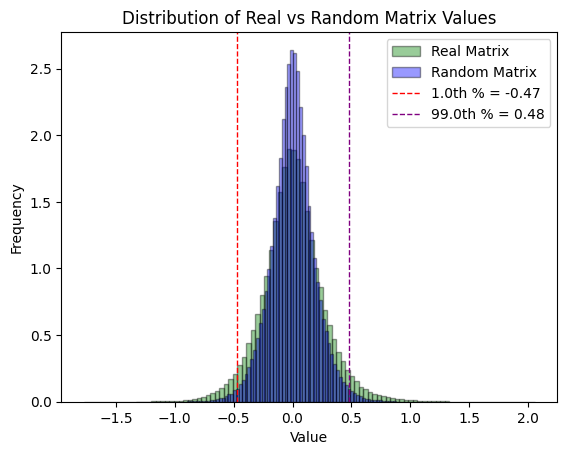

In [9]:
# Import the stored PR and real time series to compare their distribution
timeseries_REAL=pd.read_csv('TimeSeries_REAL\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)
timeseries_PR=pd.read_csv('TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)

# Flatten the matrices
real_corr_flat = np.array(timeseries_REAL).flatten()
random_corr_flat = np.array(timeseries_PR).flatten()

# Plot the distribution of correlation values for real vs random data
plt.hist(real_corr_flat, density=True, bins=100, label='Real Matrix', alpha=0.4, color='green', edgecolor='black')
plt.hist(random_corr_flat, density=True, bins=100, label='Random Matrix', alpha=0.4, color='blue', edgecolor='black')

# Calculate percentiles
q010 = np.quantile(random_corr_flat, 0.010)
q990 = np.quantile(random_corr_flat, 0.990)

# Draw red dotted lines at the 1.0th and 99.0th percentiles
plt.axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
plt.axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

# Add legend to the plot
plt.legend()

# Optional: Add titles and labels
plt.title('Distribution of Real vs Random Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

**2.	Data_to_CC: 	Timeseries + PR_timeseries -> pruned_clique_complex + entropies/mutinfo/F’s**

Define function to obtain complete clique complex of all mutual informations and function to split this into the mutual informations per dimension

In [10]:
def obtain_mutual_information(filename, max_d, number_of_variables): 

    # Import time series data
    df = pd.read_csv(filename, sep='\t', header=None)

    # Mask using the 99th and 1th percentile
    stacked_series = df.stack()
    quantile_99 = stacked_series.quantile(0.99)
    quantile_01 = stacked_series.quantile(0.01)
    df[df > quantile_99] = quantile_99
    df[df < quantile_01] = quantile_01

    # Initialize an empty DataFrame to hold discretized values
    discretized_time_series = pd.DataFrame()
    max_BOLD = df.max().max()
    min_BOLD = df.min().min()
    desired_number_of_bins = 16
    stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
    bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

    # Iterate over each column of 'df'
    for col in df.columns:
        data = df[col].tolist()
        bin_numbers = np.digitize(data, bin_edges)
        
        # Create a DataFrame with the current column's discretized values
        col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
        
        # Concatenate the new DataFrame along the columns axis
        discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

    # Import the information topology functions needed
    %run infotopo.py
    
    # Settings to use infotopo functions
    dataset = np.array(discretized_time_series).T
    work_on_transpose = False 
    nb_of_values = 16
    deformed_probability_mode = False
    supervised_mode = False
    forward_computation_mode = True
    sampling_mode = 1

    # Call infotopo functions for entropy, mutual information and free energy
    information_topo = infotopo(dimension_max = max_d, 
                                dimension_tot = number_of_variables, 
                                sample_size = 2400, 
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values, 
                                sampling_mode = sampling_mode, 
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode, 
                                forward_computation_mode = forward_computation_mode)

    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) 
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)

    return Nentropie, Ninfomut, Nfree_energy

def infomut_per_dimension(data):

    list_1 = []  # For keys of length 1
    list_2 = []  # For keys of length 2
    list_3 = []  # For keys of length 3

    for key, value in data.items():
        if len(key) == 1:
            list_1.append(value)
        elif len(key) == 2:
            list_2.append(value)
        elif len(key) == 3:
            list_3.append(value)

    return list_1, list_2, list_3

Obtain all mutual informations for the total clique complex from Real and Randomised data

In [12]:
# Run for max_d=3 and nb_variables=60 takes about 4min
Real_Nentropie, Real_Ninfomut, Real_Nfree_energy = obtain_mutual_information('Cyril\TimeSeries\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', 3, 20)
Random_Nentropie, Random_Ninfomut, Random_Nfree_energy = obtain_mutual_information('Cyril\TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', 3, 20)

2024-03-31 14:54:41,969 : INFO : PROGRESS: at percent #0
2024-03-31 14:54:41,987 : INFO : PROGRESS: at percent #1
2024-03-31 14:54:42,043 : INFO : PROGRESS: at percent #2
2024-03-31 14:54:42,080 : INFO : PROGRESS: at percent #3
2024-03-31 14:54:42,124 : INFO : PROGRESS: at percent #4


Percent of tuples processed : 0


2024-03-31 14:54:42,164 : INFO : PROGRESS: at percent #5
2024-03-31 14:54:42,208 : INFO : PROGRESS: at percent #6
2024-03-31 14:54:42,247 : INFO : PROGRESS: at percent #7
2024-03-31 14:54:42,295 : INFO : PROGRESS: at percent #8
2024-03-31 14:54:42,340 : INFO : PROGRESS: at percent #9
2024-03-31 14:54:42,396 : INFO : PROGRESS: at percent #10
2024-03-31 14:54:42,452 : INFO : PROGRESS: at percent #11
2024-03-31 14:54:42,510 : INFO : PROGRESS: at percent #12
2024-03-31 14:54:42,557 : INFO : PROGRESS: at percent #13
2024-03-31 14:54:42,605 : INFO : PROGRESS: at percent #14
2024-03-31 14:54:42,654 : INFO : PROGRESS: at percent #15
2024-03-31 14:54:42,720 : INFO : PROGRESS: at percent #16
2024-03-31 14:54:42,786 : INFO : PROGRESS: at percent #17
2024-03-31 14:54:42,843 : INFO : PROGRESS: at percent #18
2024-03-31 14:54:42,902 : INFO : PROGRESS: at percent #19
2024-03-31 14:54:42,976 : INFO : PROGRESS: at percent #20
2024-03-31 14:54:43,040 : INFO : PROGRESS: at percent #21
2024-03-31 14:54:43

Percent of tuples processed : 0


2024-03-31 14:54:52,328 : INFO : PROGRESS: at percent #6
2024-03-31 14:54:52,371 : INFO : PROGRESS: at percent #7
2024-03-31 14:54:52,417 : INFO : PROGRESS: at percent #8
2024-03-31 14:54:52,464 : INFO : PROGRESS: at percent #9
2024-03-31 14:54:52,502 : INFO : PROGRESS: at percent #10
2024-03-31 14:54:52,552 : INFO : PROGRESS: at percent #11
2024-03-31 14:54:52,602 : INFO : PROGRESS: at percent #12
2024-03-31 14:54:52,645 : INFO : PROGRESS: at percent #13
2024-03-31 14:54:52,696 : INFO : PROGRESS: at percent #14
2024-03-31 14:54:52,737 : INFO : PROGRESS: at percent #15
2024-03-31 14:54:52,797 : INFO : PROGRESS: at percent #16
2024-03-31 14:54:52,861 : INFO : PROGRESS: at percent #17
2024-03-31 14:54:52,927 : INFO : PROGRESS: at percent #18
2024-03-31 14:54:52,984 : INFO : PROGRESS: at percent #19
2024-03-31 14:54:53,050 : INFO : PROGRESS: at percent #20
2024-03-31 14:54:53,115 : INFO : PROGRESS: at percent #21
2024-03-31 14:54:53,177 : INFO : PROGRESS: at percent #22
2024-03-31 14:54:5

Split the obtained mutual informations into each dimension

In [13]:
# Split the mutual informations per dimension
Real_I1, Real_I2, Real_I3 = infomut_per_dimension(Real_Ninfomut)
Random_I1, Random_I2, Random_I3 = infomut_per_dimension(Random_Ninfomut)

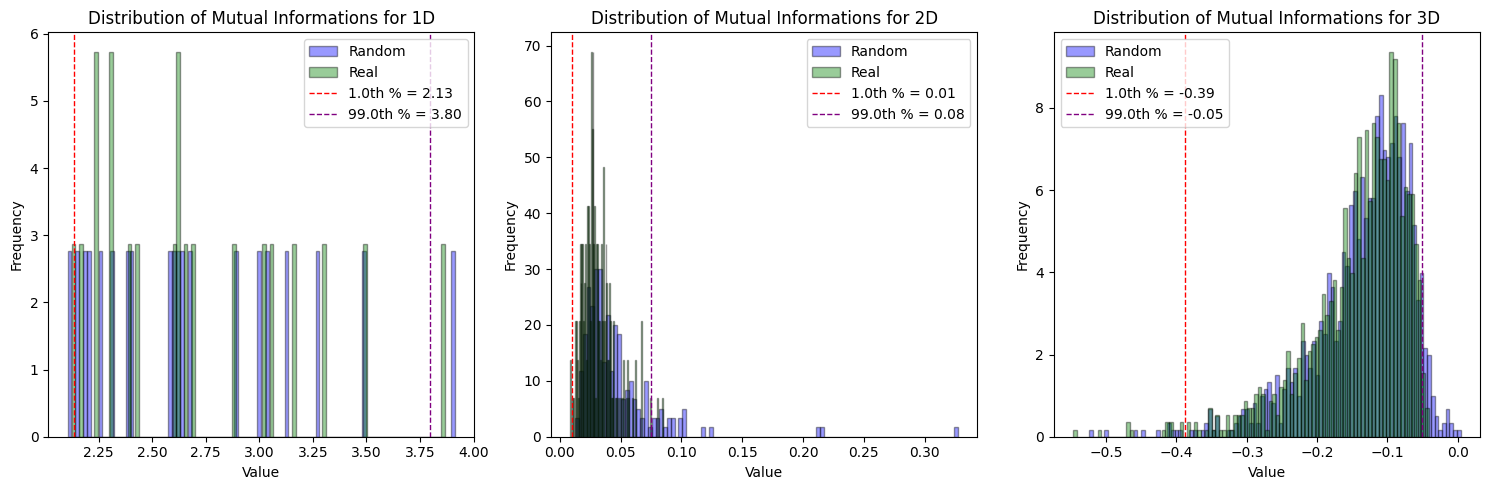

In [15]:
# Define the data
Real = [Real_I1, Real_I2, Real_I3]
Random = [Random_I1, Random_I2, Random_I3]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each set of data and plot
for i in range(3):
    Real_values = Real[i]
    Random_values = Random[i]
    
    # Plot the distribution of correlation values for real vs random data
    axes[i].hist(Real_values, bins=100, density=True, label='Random', alpha=0.4, color='blue', edgecolor='black')
    axes[i].hist(Random_values, bins=100, density=True, label='Real', alpha=0.4, color='green', edgecolor='black')

    # Calculate percentiles
    q010 = np.quantile(Random_values, 0.010)
    q990 = np.quantile(Random_values, 0.990)

    # Draw red dotted lines at the 1.0th and 99.0th percentiles
    axes[i].axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
    axes[i].axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

    # Add legend to the plot
    axes[i].legend()

    # Optional: Add titles and labels
    axes[i].set_title(f'Distribution of Mutual Informations for {i+1}D')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
# Given dictionary
data = Real_Ninfomut

# Define common quantiles
quantile_min = 0.010
quantile_max = 0.990

# Initialize a dictionary to store filtered data for different key lengths
filtered_data = {}

# Loop through the data
for key_length in range(1, 4):
    # Calculate quantiles based on the key length
    I_min = np.quantile(locals()[f"Random_I{key_length}"], quantile_min)
    I_max = np.quantile(locals()[f"Random_I{key_length}"], quantile_max)
    
    # Filter data
    mask = {key: I_min <= value <= I_max for key, value in data.items()}
    filtered_data[key_length] = {key: value for key, value in data.items() if mask[key]}

# Print filtered dictionaries
print("Filtered Dictionaries:")
for key_length, filtered_dict in filtered_data.items():
    print(len(filtered_dict), ":", filtered_dict)

# Combine filtered dictionaries into one pruned_clique_complex dictionary
pruned_clique_complex = {key: value for filtered_dict in filtered_data.values() for key, value in filtered_dict.items()}
print("Pruned Clique Complex:", pruned_clique_complex)

Filtered Dictionaries:
18 : {(1,): 2.3158932632922564, (2,): 2.6034634969390407, (3,): 2.2046295200496218, (5,): 3.0029452453336924, (6,): 2.638108973868445, (7,): 2.3989199097781473, (8,): 2.615714896072481, (9,): 2.263040738115215, (10,): 2.6811687257127006, (11,): 2.1899793141189527, (12,): 2.155641706436543, (13,): 2.885945997760527, (14,): 3.4910900719042703, (15,): 2.3930486691448194, (16,): 2.5874412804506597, (17,): 3.0427341658817033, (18,): 3.2773624179080096, (19,): 3.1300593715491387}
167 : {(1, 2): 0.03881460164945061, (1, 3): 0.03208233536630356, (1, 4): 0.018709167611643096, (1, 5): 0.025890859202976735, (1, 6): 0.025290038216225774, (1, 7): 0.021381681022933918, (1, 8): 0.02069406727950529, (1, 10): 0.04036144115299489, (1, 11): 0.02312911493224945, (1, 12): 0.014466923696759615, (1, 13): 0.03097342180340057, (1, 14): 0.02840522369813403, (1, 15): 0.016433747736248172, (1, 16): 0.0231189482678813, (1, 17): 0.051723416228326435, (1, 18): 0.04699668501089693, (1, 19): 0.0

Compute the average free energy component, i.e. mutual information, as according to Pierre Baudot. In green also included the Free energy from Pierre.

In [17]:
#average_free_energy = sum(Nfree_energy.values())/len(Nfree_energy.values())
#print(f'The average free energy of this subject is {average_free_energy}')

average_free_energy_component = sum(pruned_clique_complex.values())/len(pruned_clique_complex.values())
print(f'The free energy component (average mutual information) of this subject is {average_free_energy_component}')

The free energy component (average mutual information) of this subject is -0.07452003866378275


Output a pruned clique complex containing only simplices as desired for Knill's approach

In [21]:
print(len(pruned_clique_complex))
clique_complex = [frozenset(key) for key in pruned_clique_complex if key in pruned_clique_complex]
print(len(clique_complex))

1264
1264


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

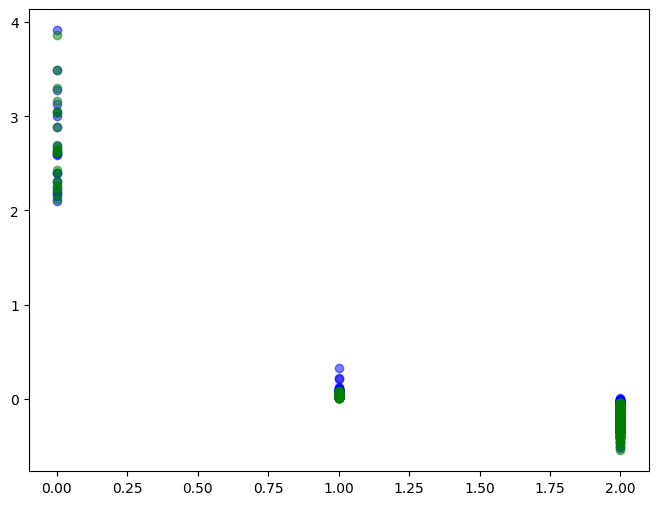

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data
Real = [Real_I1, Real_I2, Real_I3]
Random = [Random_I1, Random_I2, Random_I3]

# Create a new figure
plt.figure(figsize=(8, 6))

# Set up the color map
cmap = plt.cm.viridis

# Plot the histograms
for i in range(len(Real)):
    x = [i] * len(Real[i])
    plt.scatter(x, Real[i], color='blue', alpha=0.5)
    plt.scatter(x, Random[i], color='green', alpha=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Frequency')

# Set x-axis ticks and labels
plt.xticks(range(len(Real)), ['Real_1', 'Real_2', 'Real_3'])

# Add labels and title
plt.xlabel('Real and Random Lists')
plt.ylabel('Values')
plt.title('Histograms with Colorbar')

# Show the plot
plt.grid(True)
plt.show()

**3. CC_to_F: 	Pruned_clique_complex + L_p -> Knill’s F**

In [23]:
def count_occurrences(dicts):
    occurrences = {}
    # Iterate over all dictionaries
    for d in dicts:
        for key in d:
            occurrences[key] = occurrences.get(key, 0) + 1
    return occurrences

def generate_clique_probabilities(dict_list):  
      
    # Count occurrences
    occurrences = count_occurrences(dict_list)

    # Divide each value by the sum
    normalized_occurrences = {key: value /sum(occurrences.values()) for key, value in occurrences.items()}
    
    dict_values_list = []

    for i in range(0, len(dict_list)):
        # Initialize an empty list to store values
        values_list = []

        # Iterate over keys of dict1
        for key in dict_list[i]:
            # Check if the key exists in normalized_occurrences
            if key in normalized_occurrences:
                # If the key exists, append its corresponding value to the list
                values_list.append(normalized_occurrences[key])

        dict_values_list.append(np.array(values_list))

    return dict_values_list

In [24]:
%run Week_18_functions.py

In [30]:
# Test for some example clique_complexes
clique_complex_1 = {(1,):0.245, (2,):0.456, (1, 2): 0.123} # Put here the real pruned_clique_complex of dataset 1
clique_complex_2 = {(2,):0.767, (3,):0.178, (2, 3): 0.367} # Put here the real pruned_clique_complex of dataset 2
clique_complex_3 = {(1,):0.267, (4,):0.278, (6,): 0.128, (1, 4, 6):0.236} # Put here the real pruned_clique_complex of dataset 3 etc..
clique_complex_1 = [frozenset(key) for key in clique_complex_1 if key in clique_complex_1]
clique_complex_2 = [frozenset(key) for key in clique_complex_2 if key in clique_complex_2]
clique_complex_3 = [frozenset(key) for key in clique_complex_3 if key in clique_complex_3]
clique_complex_list = [clique_complex_1, clique_complex_2, clique_complex_3]

# Generate Free energies
F_list = []
clique_probabilities_list = generate_clique_probabilities(clique_complex_list)

for i in range(0, len(clique_complex_list)):
    clique_complex = clique_complex_list[i]
    probability = clique_probabilities_list[i]
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)
    F = energy_function(probability, inverse_connectivity_matrix)
    F_list.append(F)

print(F_list)

[-0.010000000000000002, 0.010000000000000002, 0.015000000000000003]


**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

In [31]:
clique_complex_list

[[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({2, 3})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({1, 4, 6})]]

In [32]:
from scipy.optimize import minimize

def complete_f_generator_scipy(clique_complex):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    t = 1
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

In [33]:
print('Using scipy the minimum free energy and the corresponding clique probabilities are', complete_f_generator_scipy(clique_complex_list[0]))

Using scipy the minimum free energy and the corresponding clique probabilities are [-0.4999999996999998, array([5.00000000e-01, 5.00000000e-01, 1.00000064e-10])]


F minmisation using custom P

In [34]:
def complete_f_generator(clique_complex):
    # Generate connection matrix and inverse
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    temperature = 0.5 # ratio between influence of internal energy and entropy
    iterations = 1000 # number of iterations to minimise F
    free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, iterations, temperature)

    ''' IF TEMPERATURE VARIATION
    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]
    '''
    return [max_entropy_value, min_energy_value, free_energy_history[-1], f_probabilities]

In [35]:
complete_f_generator(clique_complex_list[0])

[1.584962500721156,
 0.14285714285714285,
 -0.8024211874631666,
 array([0.45852179, 0.45413844, 0.08733978])]